# Лабораторная работа 4.3.1

#### Исследование дифракции Френеля и Фраунгофера на узкой длинной щели

### Библиотеки 

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import math as m
import random as r

from scipy.optimize import curve_fit
from scipy.integrate import quad

In [3]:
def Line(x, a, b):
    """
    Параметрическая прямая
    """
    return a*x + b

#-----------------------------------------------------------------------------------------------------------
#
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! ВНИМАНИЕ !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#
# Тупой питон не может подставить знак минус перед коэффициентом b! Если экспонента имеет вид e(^b), b < 0,
# то минус надо указать вручную.
#
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#
#-----------------------------------------------------------------------------------------------------------
def Exponent(x, a, b, c):
    """
    Параметрическая експонента (ae^(bx)
    """
    return a * np.exp(-b * x) + c

def CalcErrors(popt, cov, precA = 4, precB = 4, printRes = True):
    """
    Вычисляет погрешность МНК.
    Выводит в консоль значения + погрешность.
    Возвращает массив погрешностей.
    """
    errors = []
    for i in range(len(popt)):
        try:
          errors.append(np.absolute(cov[i][i])**0.5)
        except:
          errors.append( 0.00 )
    errors = np.array(errors)

    if (printRes == True):
        print("a = {:.0{prec}f} sig_a = {:.0{prec}f}".format(popt[0], errors[0], prec = precA))
        print("b = {:.0{prec}f} sig_b = {:.0{prec}f}".format(popt[1], errors[1], prec = precB), '\n')

    return errors

def NpToStrList(np_array, precision):
    np_array = np.around(np_array.astype(float), precision)

    return ["{:.0{prec}f}".format(val, prec = precision) for val in np_array]

def NpToStr(array):
    return [str(f) for f in array]

def PrintMinMax(array, header):
    print(header + "min = {:.3f}, max = {:.3f}".format(min(array), max(array)))
    
#jnb.HideCell()

In [4]:
def _getIndex(indexRow, indexColumn, isRowDataSet):
    """
    Возвращает индексы в правильном порядке для обращения к массиву.
    """
    if (isRowDataSet == True):
        return (indexRow, indexColumn)
    else:
        return (indexColumn, indexRow)

def _drawRowGrid(file, rowGrid, rowIndex):
    if (rowGrid != None and rowGrid[rowIndex] > 0):
         file.write("\\hline\n" * rowGrid[rowIndex])

def _getTableDim(data, isRowDataSet):
    if (isRowDataSet == True):
        return (len(data), len(data[0]))
    else:
        return (len(data[0]), len(data))

def _createTable(fileName, data, isRowDataSet, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт вертикальную Latex-таблицу, если rowDataSet == false и горизонтальную, если rowDataSet == true.

    Аргументы:
    fileName     - имя выходного файла с таблицей;
    data         - массив данных таблицы;
    isRowDataSet - если true, массив данных содержит горизонтальную таблицу, иначе вертикальную;
    columnGrid   - строка, которая определяет тип сетки между колонками: \begin{tabular}{columnGrid};
    rowGrid      - список длины rowCount + 1, в котором содержится число:
                        - 0 - нет       горизонтальной линии;
                        - 1 - одинарная горизонтальная линия;
                        - 2 - двойная   горизонтальная линия.
    """
    rowCount, columnCount = _getTableDim(data, isRowDataSet)

    with open("tables\\" + fileName, 'w', encoding='utf-8') as file:

        if (columnGrid == None):
            columnGrid = "|" + 'c|' * columnCount
        
        file.write("\\begin{tabular}[t]{" + columnGrid +"}\n")

        _drawRowGrid(file, rowGrid, 0)
        
        if (preheader != None):
            file.write(preheader)

        for rowIndex in range(0, rowCount):

            for colIndex in range(0, columnCount - 1):
                index1, index2 = _getIndex(rowIndex, colIndex, isRowDataSet)

                file.write("{} & ".format(str(data[index1][index2]).replace('.', ',')))

            index1, index2 = _getIndex(rowIndex, columnCount - 1, isRowDataSet)

            file.write("{} \\\\ \n".format(str(data[index1][index2]).replace('.', ',')))

            _drawRowGrid(file, rowGrid, rowIndex + 1)

        # End data draw cycle
        file.write('\end{tabular}')

def CreateVerticalTable(fileName, data, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт вертикальную Latex-таблицу.
    """
    _createTable(fileName, data, False, columnGrid = columnGrid, rowGrid = rowGrid, preheader = preheader)

def CreateVerticalTableHeader(fileName, header, dataColumns, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт вертикальную Latex-таблицу.
    """
    _createTable(fileName, [[header[st]] + dataColumns[st] for st in range(0, len(dataColumns))],
                                False, columnGrid = columnGrid, rowGrid = rowGrid, preheader = preheader)

def CreateHorizontalTable(fileName, dataRows, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт горизонтальную Latex-таблицу.
    """
    _createTable(fileName, dataRows, True, columnGrid = columnGrid, rowGrid = rowGrid, preheader = preheader)
    

### Дифракция Френеля

In [5]:
x0 = 51.7 # см
fresnel = {
    "z" : [x0 - 49.7, x0 - 50.4, x0 - 50.8, x0 - 51.0, x0 - 51.1], # см
    "xi": [],
    "sig_xi": [],
    "n" : [2, 3, 4, 5, 6], 
    "slite_width" : 0.24, # мм
    "lambda": 578, # нм
    "sig_z" : 0.01
}

for st in range(0, len(fresnel["z"])):
    z = fresnel["z"][st]
    xi = (z * 10**(-2) * fresnel["n"][st] * fresnel["lambda"] * 10**(-9))**0.5 # м
    sig_xi = (fresnel["sig_z"]/z) * xi

    xi *= 1000
    sig_xi *= 1000
    
    fresnel["sig_xi"].append(sig_xi)
    fresnel["xi"].append(xi)
    
    print("#" + str(st + 1), xi, "+-", sig_xi, "мм", fresnel["z"][st] * 10, "мм")

fresnel["sig_xi"] = np.array(fresnel["sig_xi"])
fresnel["xi"] = np.array(fresnel["xi"])
fresnel["n"] = np.array(fresnel["n"])

#1 0.1520526224699857 +- 0.0007602631123499286 мм 20.0 мм
#2 0.15013993472757364 +- 0.0011549225748274858 мм 13.000000000000043 мм
#3 0.14424978336205616 +- 0.0016027753706895026 мм 9.000000000000057 мм
#4 0.14223220451079313 +- 0.002031888635868465 мм 7.000000000000028 мм
#5 0.14424978336205588 +- 0.0024041630560342592 мм 6.000000000000014 мм


In [6]:
xi_count = len(fresnel["xi"])
av_xi = 2 * sum(fresnel["xi"] / xi_count)

sig_xi = math.sqrt(1 / (xi_count * (xi_count - 1)) * np.sum((2 * fresnel["xi"] - av_xi)**2))

print(av_xi, "+-", sig_xi, "мм")

NameError: name 'math' is not defined

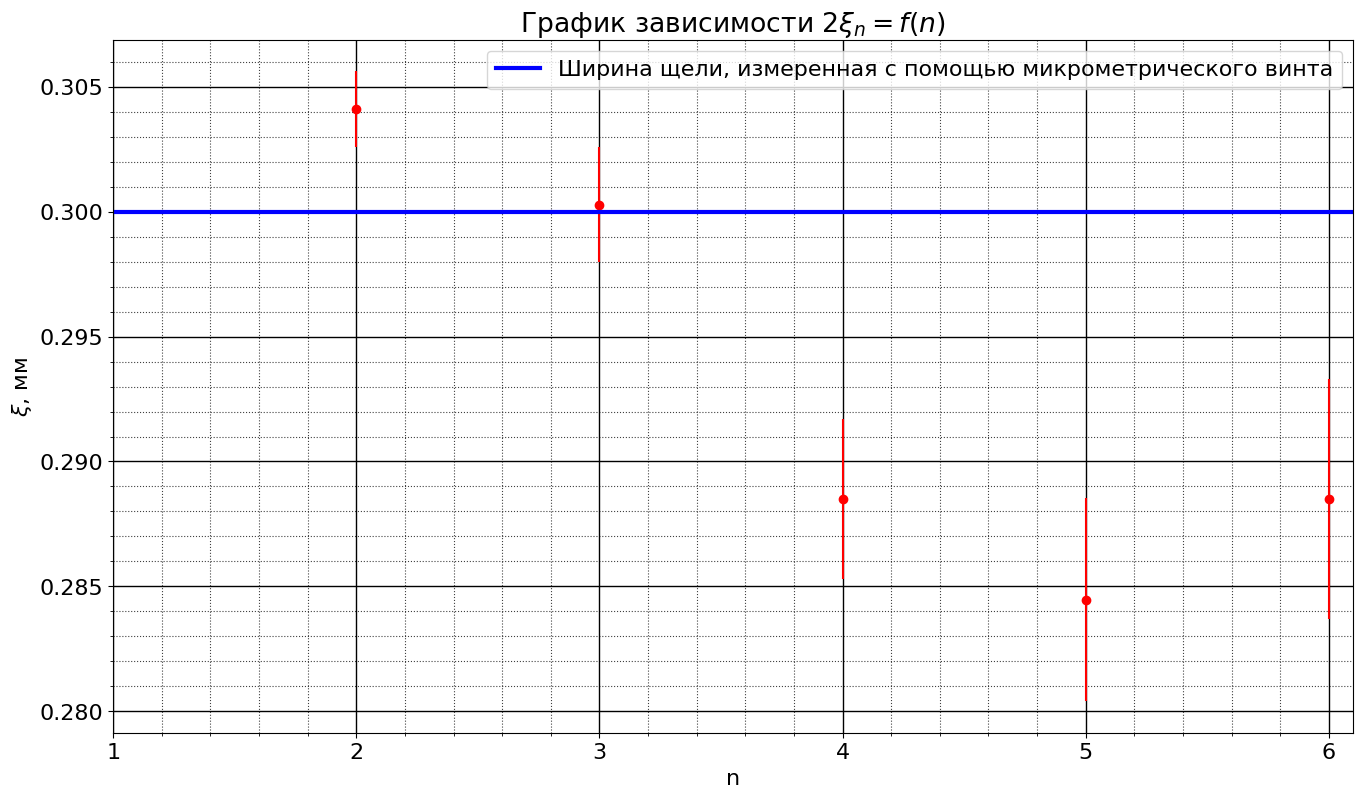

In [ ]:
mpl.rcParams['font.size'] = 16 # Управление стилем, в данном случаем - размером шрифта 

# Создаем фигуру
plt.figure(figsize=(16,9))

# Подписываем оси и графи
plt.title(r"График зависимости $2\xi_n = f(n)$")
plt.xlabel(r"n")
plt.ylabel(r"$\xi$, мм")

# Добавляем данные
plt.plot(fresnel["n"], 2 * fresnel["xi"], 'o', color = 'r')
plt.errorbar(fresnel["n"], 2 * fresnel["xi"], yerr = 2 * fresnel["sig_xi"], fmt = '+', color = 'r')

x = np.array([1, 7])
plt.plot(x , Line(x , 0, 0.3), color = 'b', linewidth = 3, label = "Ширина щели, измеренная с помощью микрометрического винта")
# Из мнк

#plt.plot(x2, y2, c = 'b')
#plt.plot(0, 0, c = 'w')
#'r^' - задает стиль линии - красные (red) треугольники (^), подробнее в документации

# Активируем сетку
ax = plt.subplot()
ax.minorticks_on()

x_major_ticks = np.arange(1, 6.1, 1)
ax.set_xticks(x_major_ticks)
plt.xlim([1, 6.1])
#  Определяем внешний вид линий основной сетки:
ax.grid(which = 'major', color = 'k', linewidth = 1)

#  Определяем внешний вид линий вспомогательной
#  сетки:
ax.grid(which = 'minor', color = 'k', linestyle = ':')

plt.grid(visible = True, which = 'major', axis = 'both', alpha = 1)
plt.grid(visible = True, which = 'minor', axis = 'both', alpha = 0.75)

# Активируем легенду графика
plt.legend()

# Сохраняем изображение в текущую директорию
plt.savefig('Изображения/xi_f(n).png')

# Внимание, запускаете вашу программу как сценарий, то что бы показать график
# Используйте эту команду
plt.show()

### Фраунгофер. Двойная щель.

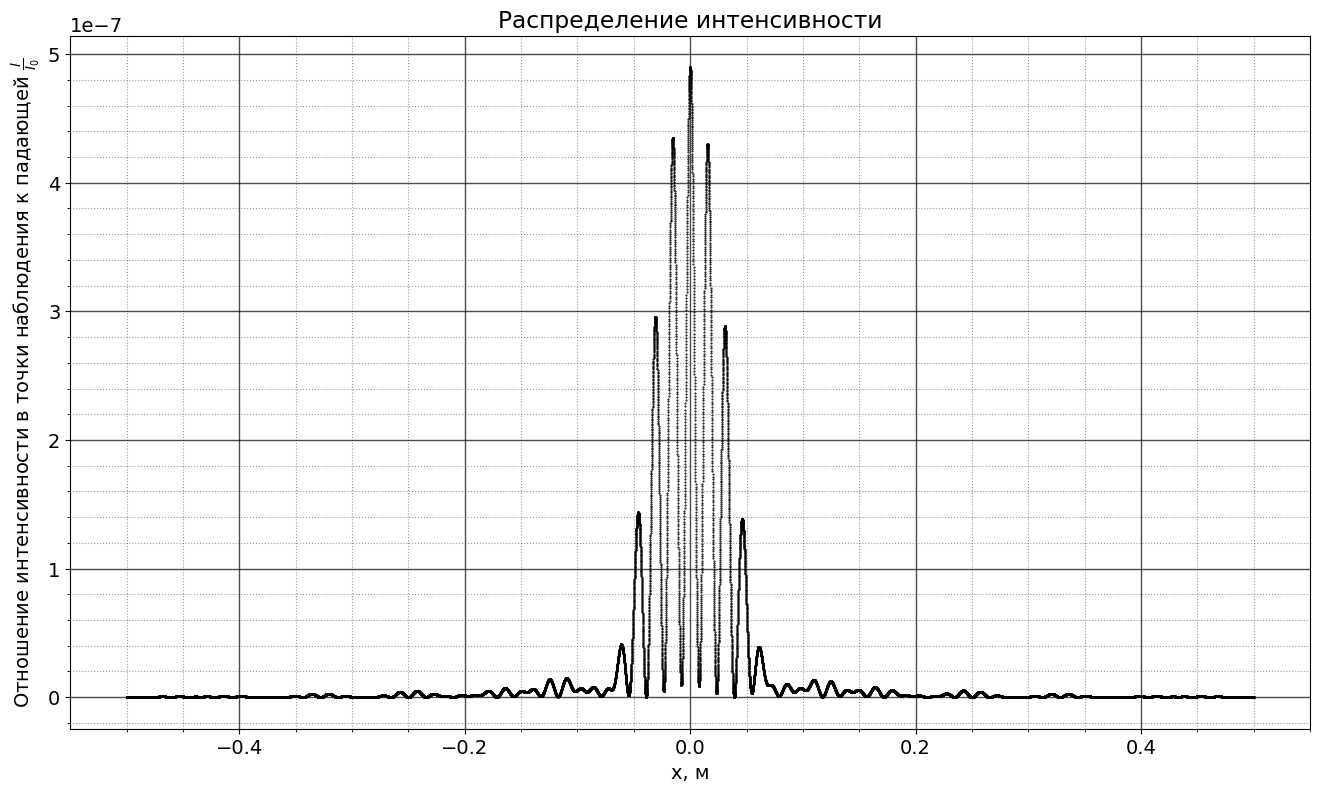

In [13]:
mpl.rcParams['font.size'] = 14 # Управление стилем, в данном случаем - размером шрифта 

# Создаем фигуру
plt.figure(figsize=(16,9))

# Подписываем оси и график
plt.title(r"Распределение интенсивности")
plt.xlabel(r"x, м")
plt.ylabel("Отношение интенсивности в точки наблюдения к падающей $\\frac{I}{I_0}$")

# Добавляем данные
x = np.linspace(-0.5, 0.5, 40000) # м
wave_length =578e-9 # м
k = 2*m.pi/wave_length

d1 = 400e-6 # м
d2 = 300e-6 # м
D  = 1500e-6 # м
A0 = 1

z = 50 # м

def Intesive(xi, x):
    return m.cos(k / (2 * z) * (x - xi)**2)
    
def IntesiveSin(xi, x):
    return m.sin(k / (2 * z) * (x - xi)**2)

y = []

xi_1 = -d1 - D/2
xi_2 = D / 2

for _x in x:
    I1 = quad(Intesive, xi_1, xi_1 + d1, args = (_x))[0] + 1j * quad(IntesiveSin, xi_1, xi_1 + d1, args = (_x))[0]
    I2 = quad(Intesive, xi_2, xi_2 + d2, args = (_x))[0] + 1j * quad(IntesiveSin, xi_2, xi_2 + d2, args = (_x))[0]

    I = abs(I1 + I2)**2

    y.append(I)

y = np.array(y)

plt.plot(x, y, '.', color = 'k', markersize = 1)

# Активируем сетку
ax = plt.subplot()
ax.minorticks_on()

#  Определяем внешний вид линий основной сетки:
ax.grid(which = 'major', color = 'k', linewidth = 1)

#  Определяем внешний вид линий вспомогательной
#  сетки:
ax.grid(which = 'minor', color = 'k', linestyle = ':')

plt.grid(visible = True, which = 'major', axis = 'both', alpha = 0.7)
plt.grid(visible = True, which = 'minor', axis = 'both', alpha = 0.4)

# Активируем легенду графика
#plt.legend()

# Сохраняем изображение в текущую директорию
plt.savefig('Int_I.png')

# Внимание, запускаете вашу программу как сценарий, то что бы показать график
# Используйте эту команду
plt.show()

In [154]:
idx0 = 23000
_y = y[idx0:]
print("a")
print(_y.argmax())
print(y[idx0 + _y.argmax()])

delta = (idx0 + _y.argmax()) * 0.5 / 40000
print(delta / z)
print(wave_length / D)

a
8985
5.53197142637318e-07
0.000799625
0.00038533333333333334


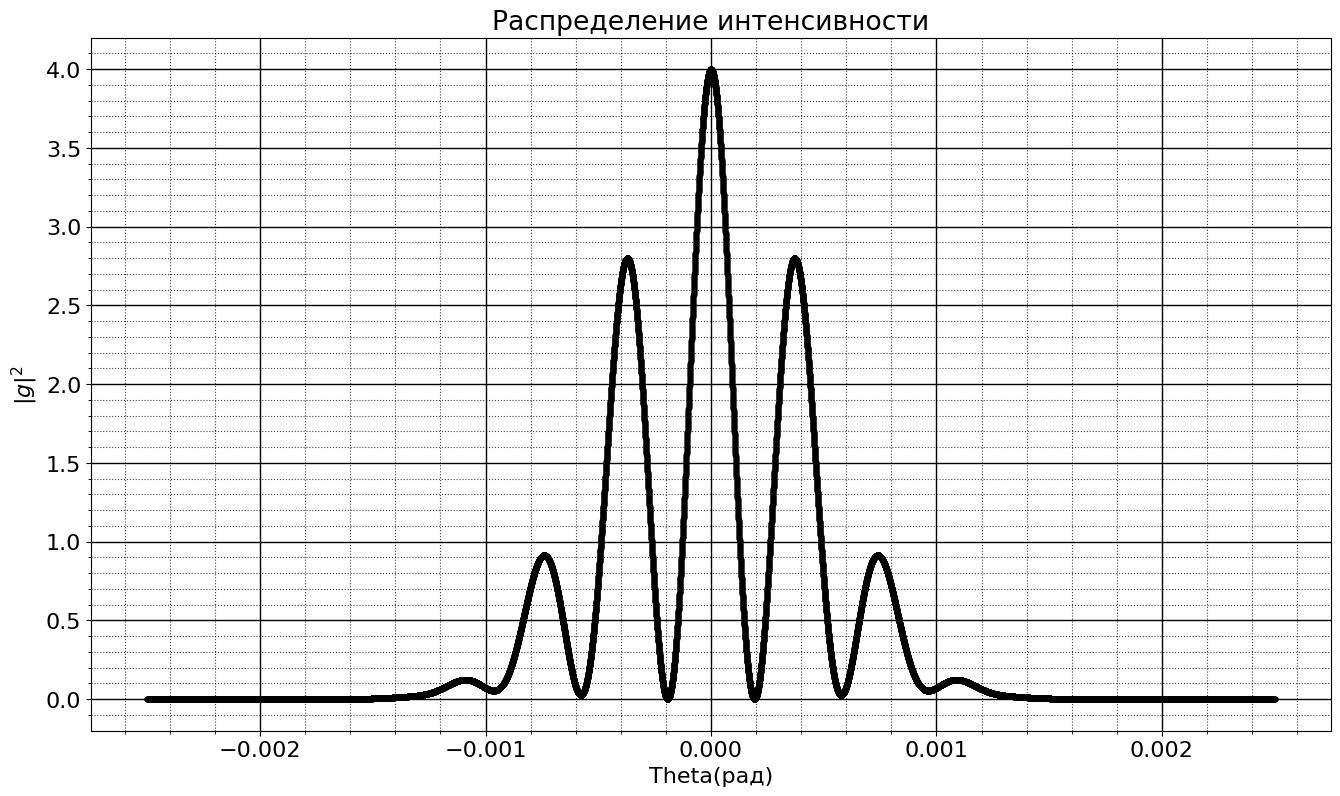

In [6]:

mpl.rcParams['font.size'] = 16 # Управление стилем, в данном случаем - размером шрифта 

# Создаем фигуру
plt.figure(figsize=(16,9))

# Подписываем оси и график
plt.title(r"Распределение интенсивности")
plt.xlabel(r"Theta(рад)")
plt.ylabel(r"$|g|^2$")

# Добавляем данные
x = np.linspace(-1/400, 1/400, 50000)
l = 578e-9



k = 2*m.pi/l
b1 = 4e-4
b2 = 3e-4
d = 15e-4

def f (x, b):
    return (np.sin(k*b/2 * np.sin(x)) / (k*b/2 * np.sin(x)))**2

y = (f(x,b1)*f(x,b1) + f(x,b2)*f(x,b2) + 2*f(x,b1)*f(x,b2)*np.cos(k*d*np.sin(x)))



plt.plot(x, y, '.', color = 'k')
#'r^' - задает стиль линии - красные (red) треугольники (^), подробнее в документации

# Данные с ошибками
#mu = np.sin(x2)
#sigma = np.abs(mu)**0.5
#y2 = np.random.normal(mu, sigma)
# Можно рисовать ошибки
#plt.errorbar(x, y, yerr = 0.01, fmt = '+', color = 'r')

# Активируем сетку
ax = plt.subplot()
ax.minorticks_on()

#  Определяем внешний вид линий основной сетки:
ax.grid(which = 'major', color = 'k', linewidth = 1)

#  Определяем внешний вид линий вспомогательной
#  сетки:
ax.grid(which = 'minor', color = 'k', linestyle = ':')

plt.grid(visible = True, which = 'major', axis = 'both', alpha = 1)
plt.grid(visible = True, which = 'minor', axis = 'both', alpha = 0.75)

# Активируем легенду графика
#plt.legend()

# Сохраняем изображение в текущую директорию
plt.savefig('I.png')

# Внимание, запускаете вашу программу как сценарий, то что бы показать график
# Используйте эту команду
plt.show()